In [179]:
# Sources
# Implementation adapted from: 
# [1] https://deparkes.co.uk/2021/09/05/python-timeline-plot/
# [2] https://matplotlib.org/stable/gallery/lines_bars_and_markers/broken_barh.html

# Imports 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plot configuration constants
WIDTH = 1/3
offset = WIDTH

In [180]:
source = pd.read_csv("./books.csv")

source['start'] = pd.to_datetime(source['start'])
source['end'] = pd.to_datetime(source['end'])
source['diff'] = source['end'] - source['start']
source

,name,series,start,end,diff
0,book 1,A,2019-08-01,2020-09-03,399 days
1,book 2,A,2021-05-15,2021-11-12,181 days
2,book 3,A,2022-09-01,2023-12-25,480 days
3,book A,B,2020-06-06,2021-03-02,269 days
4,book B,B,2022-02-27,2022-12-12,288 days
5,ORR,-,2019-08-07,2020-03-14,220 days
6,TGOA,-,2020-10-20,2021-07-03,256 days
7,KoA,-,2021-11-01,2021-12-05,34 days
8,TMToT,-,2022-01-15,2022-06-09,145 days
9,S&TMFoA,-,2020-02-12,2021-03-04,386 days


In [181]:
# Convert dates to a floating point representation of the year from Unix seconds timestamp
source.start = source.start.map(lambda x: (x.timestamp()/(3600*24*365))+1970)

In [182]:
def checkCollision(a,b):
    # checks if the two elements have a non-zero intersect, returning true if they do

    # setup
    a_s = a['start']
    a_e = a_s + a['duration']

    b_s = b['start']
    b_e = b_s + b['duration']

    # If one element starts after the other ends, we're good
    if a_s > b_e:
        return False
    if b_s > a_e:
        return False
    
    # if one event hasn't ended by the time that the next one has started,
    # there is a collision
    return True

In [183]:
# Group tables by common series
series_groups = {}
series_data = {}
series_idx = {}
idx = -1
for series in source.series.unique():
    idx+=1
    series_groups[series] = source[source.series == series]   # sg[s] = data | where {$_.series = series}

    series_data[series] = []
    series_idx[series] = idx

    for i, row in series_groups[series].sort_values(by='start').reset_index().iterrows():
        submit_data = {
            "start": row.start,
            "duration": row['diff'].days/365,
            "name": row['name'].strip(),
            "position": idx
        }

        # Adjust submit_data by offsetting for any other matching elements in the series
        collisions = [d for d in series_data[series] if d["position"] == submit_data["position"] and checkCollision(d, submit_data)]
        while len(collisions) != 0:
            c = collisions[0]
            print(f"input point '{submit_data['name']}' ({round(submit_data['start'],3)}, {round(submit_data['start'] + submit_data['duration'],3)})", "\tcollided with:", f"'{c['name']}' ({round(c['start'],3)}, {round(c['start'] + c['duration'],3)})")
            submit_data['position'] += offset
            collisions = [d for d in series_data[series] if d["position"] == submit_data["position"] and checkCollision(d, submit_data)]

        series_data[series].append(submit_data)
# series_data

input point 'S&TMFoA' (2020.148, 2021.205) 	collided with: 'ORR' (2019.63, 2020.233)
input point 'Cider Recipes' (2021.732, 2023.044) 	collided with: 'Overflow' (2021.701, 2022.647)
input point 'KoA' (2021.868, 2021.962) 	collided with: 'Overflow' (2021.701, 2022.647)
input point 'KoA' (2021.868, 2021.962) 	collided with: 'Cider Recipes' (2021.732, 2023.044)
input point 'TMToT' (2022.074, 2022.471) 	collided with: 'Overflow' (2021.701, 2022.647)
input point 'TMToT' (2022.074, 2022.471) 	collided with: 'Cider Recipes' (2021.732, 2023.044)


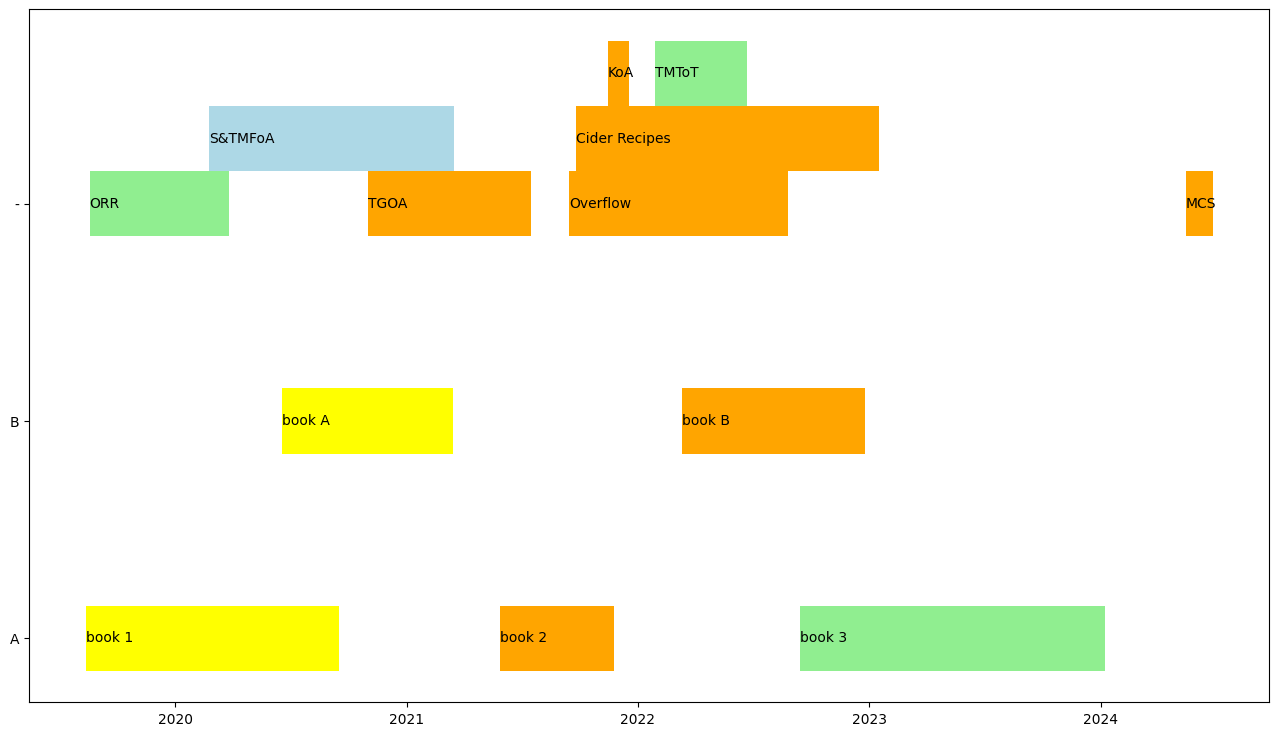

In [184]:
# next 5 directly from the source [1], except y_tick_labels
fig, gnt = plt.subplots(figsize=(16,9)) 
y_tick_labels = source.series.unique()
y_pos = np.arange(len(y_tick_labels))
gnt.set_yticks(y_pos)
gnt.set_yticklabels(y_tick_labels)

def get_color():
    colors = [
        'orange', 'lightgreen', 'lightblue', 'tan', 'yellow'
    ]
    return np.random.choice(colors)

for series in source.series.unique():
    for row in series_data[series]:
        gnt.broken_barh([(row['start'], row['duration'])], 
                        (row['position'] - WIDTH/2, WIDTH), 
                        facecolors = get_color(),
                        label=row['name'])
        gnt.text(row['start'], row['position'] - WIDTH/20, row['name'])